In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
from keras.optimizers import Adam

In [4]:
path_to_csv = './Handwritten_Data/English_Handwritten.csv'
data = pd.read_csv(path_to_csv).astype('float32')
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
width, height, channel = 28, 28, 1

In [6]:
shapelen = 372450 # engval
X = data.iloc[:,1:].values
X = X.reshape((shapelen, width, height))
np.random.shuffle(X)
X.shape

(372450, 28, 28)

In [7]:
X = (X - 127.5) / 127.5

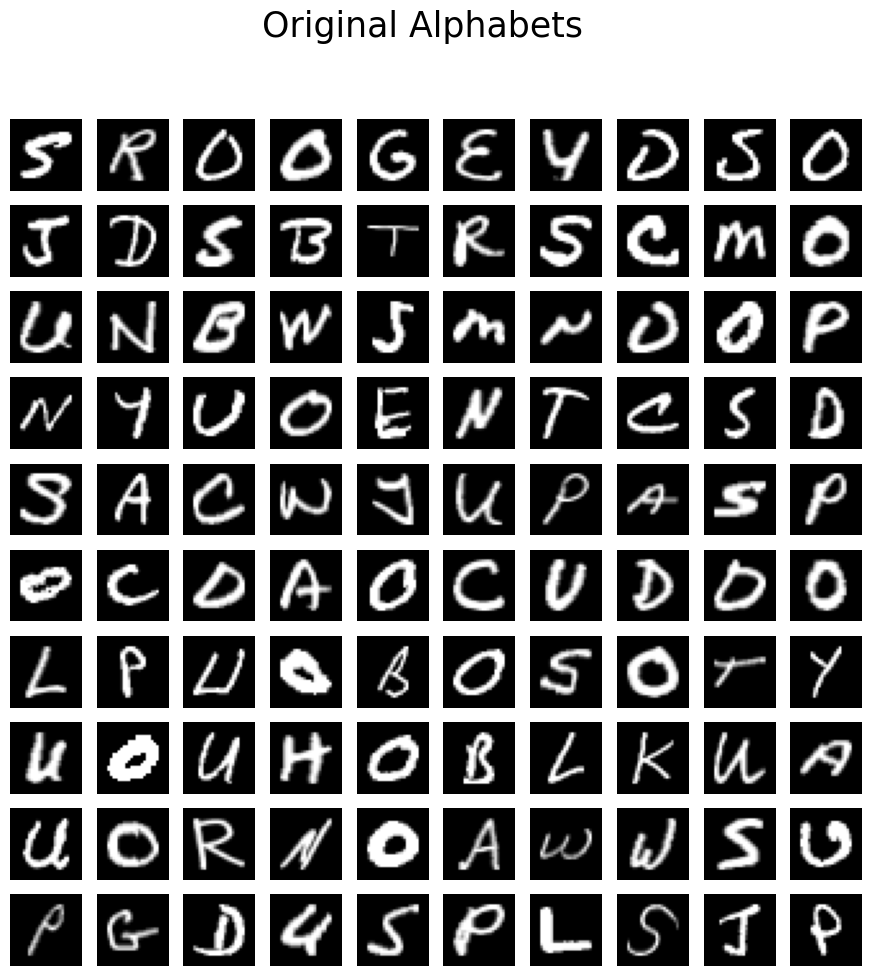

In [8]:
def show_data(X, title=""):
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in X:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height, width)), cmap='gray')
        plt.axis('off')
        i+=1
        if i>100: break

    plt.suptitle(title, fontsize = 25)
    plt.show()
    
show_data(X, title="Original Alphabets")

In [7]:
gen_optimizer = Adam(0.0001, 0.5)
disc_optimizer = Adam(0.0002, 0.5)
noise_dim = 100

In [8]:
def buildGenerator():
    model = Sequential()

    model.add(Dense(1024, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Dense(6272, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Reshape((7, 7, 128)))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(channel, (3, 3), padding='same', activation = "tanh", 
                     kernel_initializer=RandomNormal(0, 0.02)))
    
    return model

In [10]:
generator = buildGenerator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1024)              103424    
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 6272)              6428800   
                                                                 
 batch_normalization_4 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 6272)             

In [11]:
def buildDiscriminator():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=2, padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02), 
                     input_shape=(width, height, channel)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, (5, 5), strides=2, 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
    return model

In [12]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 5, 5, 128)         0         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               819456    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)              

In [13]:
noise = Input(shape=(noise_dim,))
fake_data = generator(noise)
discriminator.trainable = False
output = discriminator(fake_data)
gan = Model(noise, output)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [14]:
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         6595073   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 1026305   
                                                                 
Total params: 7,621,378
Trainable params: 6,580,353
Non-trainable params: 1,041,025
_________________________________________________________________


In [15]:
fixed_noise = np.random.normal(0, 1, size=(100, noise_dim))

In [16]:
def show_generated_alphabets(title, epoch):
    imgs = generator.predict(fixed_noise)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height,width)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 25)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

In [18]:
epochs = 81
batch_size = 128
steps_per_epoch = len(X)//batch_size
# len(X)

372450

In [ ]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_data = generator.predict(input_gen)
        
        real_data = X[np.random.randint(0, X.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, width, height, channel))
        
        input_disc = np.concatenate((real_data, fake_data))

        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9
        label_disc[batch_size:] = 0.1
        loss_disc = discriminator.train_on_batch(input_disc, label_disc)

        label_gen = np.ones(batch_size)
        loss_gen = gan.train_on_batch(input_gen, label_gen)

    print("epoch: ", epoch)
    print("discriminator loss: ", loss_disc)
    print("generator loss: ", loss_gen)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_generated_alphabets("Generated Alphabets", epoch)